In [ ]:
출처: https://github.com/MijeongJeon/KoreanGAN_GANADARAMA

참고 링크 : [Tensorflow GAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)

# **가나다라마 GAN Model** - 삐뚤빼뚤 한글 이미지 생성


![](http://dl.dropbox.com/s/fwgtnejuk8nkv16/korean-gan-image.png?)




* Part1. 프로젝트 셋팅
* Part2. 데이터 준비
* Part3. 생성자 모델 
* Part4. 판별자 모델
* Part5. Optimizer + Loss Function
* Part6. GAN Model 학습


---


# Part1. 프로젝트 셋팅

In [1]:
# 1-1. 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

print("Tensorflow Version: %s" % tf.__version__)
print("Keras Version: %s" %tf.keras.__version__)

Tensorflow Version: 2.12.0
Keras Version: 2.12.0




---



# Part2. 데이터 준비

In [ ]:
import os
os.getcwd()

In [3]:
# 2-1. CSV 데이터 읽어오기
import pandas as pd

data = pd.read_csv('dataset/image_pixels_augmented.csv', header=None).astype('float32')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,255.0,255.0,254.0,253.0,250.0,249.0,251.0,254.0,251.0,253.0,...,244.0,255.0,252.0,253.0,252.0,255.0,254.0,252.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,...,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,248.0,255.0,255.0,252.0,252.0,255.0,253.0,255.0,253.0,...,249.0,251.0,255.0,255.0,252.0,253.0,252.0,254.0,253.0,250.0
3,255.0,249.0,253.0,255.0,250.0,250.0,252.0,244.0,255.0,255.0,...,253.0,251.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [4]:
data.values.shape

(9963, 1024)

In [5]:
# 2-2. 3D Vector 변환

width, height, channel = 32, 32, 1 # 이미지 사이즈 32*32 pixel

X = data.values
X = X.reshape((X.shape[0], width, height, channel))

print(X.shape)

(9963, 32, 32, 1)


In [6]:
# 2-3. Image Pixel Normalization [0,255] -> [-1,1] 

X = (X - 127.5) / 127.5 

print(X[0])

[[[1.        ]
  [1.        ]
  [0.99215686]
  ...
  [0.99215686]
  [0.9843137 ]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.9843137 ]
  [1.        ]
  [1.        ]]

 [[0.99215686]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [0.99215686]
  [0.99215686]]

 ...

 [[0.99215686]
  [1.        ]
  [0.99215686]
  ...
  [0.9843137 ]
  [0.99215686]
  [1.        ]]

 [[1.        ]
  [1.        ]
  [0.9843137 ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]

 [[1.        ]
  [0.99215686]
  [1.        ]
  ...
  [0.9764706 ]
  [1.        ]
  [1.        ]]]


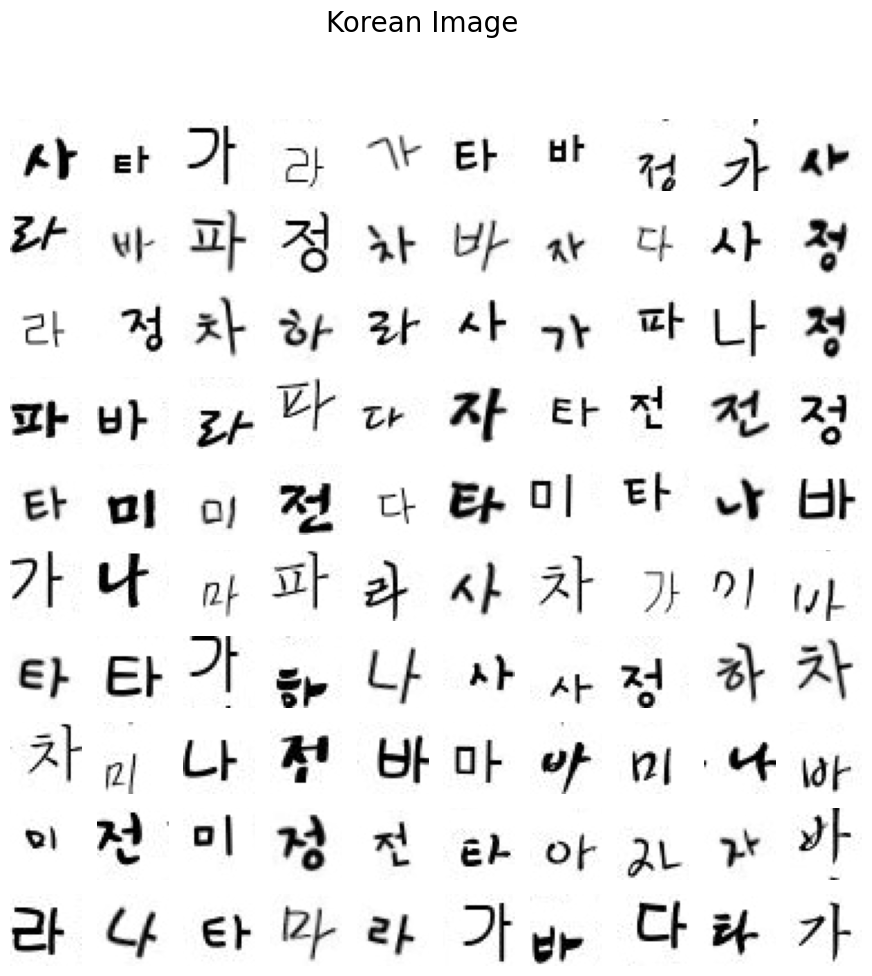

In [7]:
# 2-4. 한글 이미지 시각화
 
plt.figure(figsize=(11,11))
    
i = 1
for image in X:
    plt.subplot(10, 10, i) #(10*10) 총 100칸
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray') # 흑백 이미지
    plt.axis('off')
    i+=1
    if i > 100: break

plt.suptitle("Korean Image", fontsize = 20)
plt.show()

<img src='https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC'>

In [8]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [9]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [10]:
# 2-5. 학습 데이터 batch 준비

BATCH_SIZE = 64
# Input dataset + image randum shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH_SIZE)
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>




---




# Part3. 생성자 모델(Generator Model)

In [11]:
# 3-1. Generator 모델 네트워크 구성

def build_generator_model():
    model = tf.keras.Sequential() # Keras 모델 생성

    model.add(layers.Dense(1024, input_dim=100, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Resahpe (8*8)
    model.add(layers.Reshape((8, 8, 128)))  
    
    model.add(layers.Conv2DTranspose(128, (5, 5), 
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    
    # (8*8) -> (16*16)
    model.add(layers.Conv2DTranspose(64, (5, 5), 
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # (16*16) -> (32*32)
    model.add(layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [12]:
# 3-2. 생성자 모델 생성

generator = build_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              102400    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              8388608   
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8192)              0

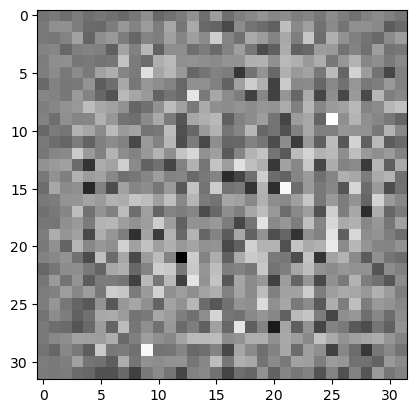

In [13]:
# 3-3. 학습되지 않은 생성자 모델이 만든 이미지

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')



---



# Part4. 판별자 모델(Discriminator Model)

In [14]:
# 4-1. Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same', 
                       input_shape=[32, 32, 1])) # input image size
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    
    return model

In [15]:
# 4-2. 판별자 모델 생성

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [16]:
# 4-3. 학습되지 않은 판별자의 결과

predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[0.00360127]], shape=(1, 1), dtype=float32)




---




# Part5. Optimizer + Loss Function

In [17]:
# 5-1. Optimizer 생성

# 생성자용
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 판별자용
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
# 5-2. BinaryCrossentropy for minMax

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

![](http://dl.dropbox.com/s/0ro2ny0enzmpx8n/gan_min_max.png)

In [19]:
# 5-2. Generator Loss 함수

# 생성자 모델 목표 : 
# 판별자 모델이 가짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1과 가짜 이미지를 판별 값 비교

In [20]:
# 5-3. Discriminator Loss 함수

# 판별자 모델 목표 :
# 1. 진짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
# 2. 가짜 이미지를 판별했을 때 판별 값이 0에 가까워지도록
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1. 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 2. 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss
    return total_loss



---




# Part6. GAN 학습(G+D) 

In [21]:
# 6-1. 학습 값 설정

EPOCHS = 300
noise_dim = 100

In [22]:
@tf.function
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
        fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
# 6-4. 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([100, noise_dim]) # 학습 시각화를 위한 테스트 노이즈

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()

In [24]:
# 6-4. 학습 코드
def train(dataset, epochs):
    for epoch in range(epochs): # 전체 데이터 학습 반복 횟수(300)
  
        for image_batch in dataset: # batch 학습(64)
            train_step(image_batch)

        print("%s epochs trained" % epoch)

        if epoch % 5 == 0: # 5번째 에포크 마다 이미지 시각화
            show_generated_images(epoch)

0 epochs trained
4/4 [==============================] - 0s 16ms/step


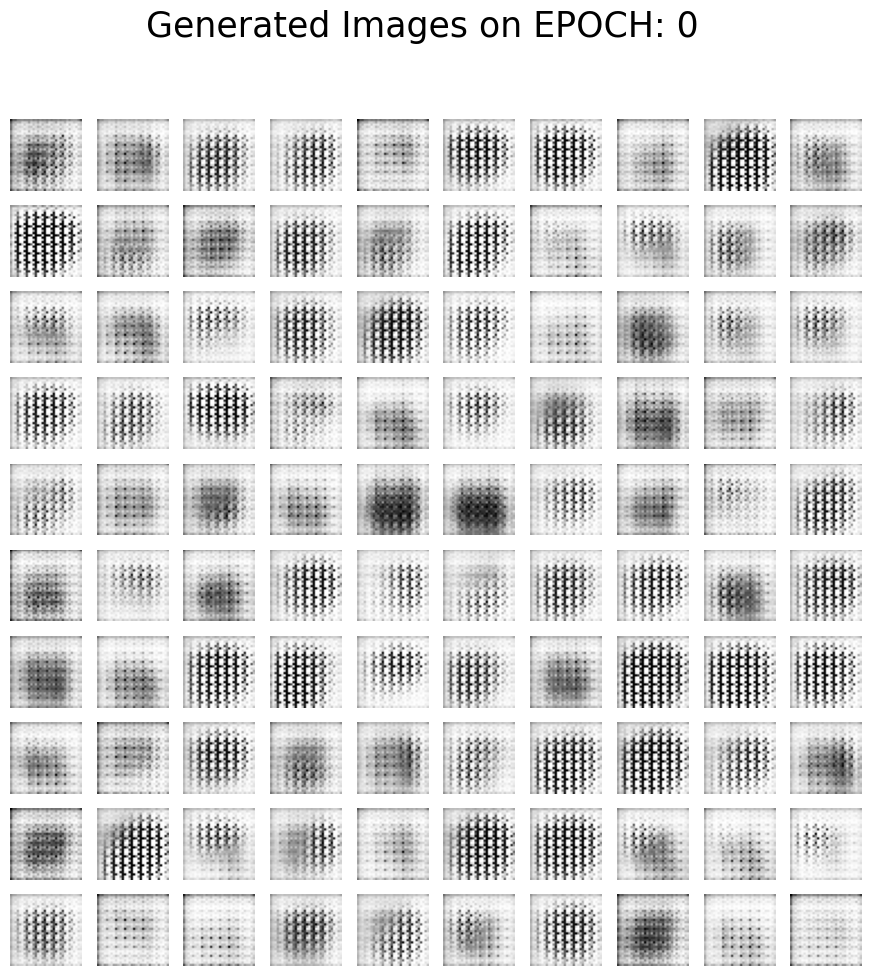

1 epochs trained


In [ ]:
# 6-5. 학습 시작!
train(train_dataset, EPOCHS)